In [2]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
  
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets 

X_trans = X.copy()
  

In [3]:
binary_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
binary_mapping = {'Male': 1, 'Female': 0, 'yes': 1, 'no': 0}

for col in binary_columns:
    X_trans[col] = X_trans[col].map(binary_mapping)


ordinal_columns = ['CAEC', 'CALC']
ordinal_mapping = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}

for col in ordinal_columns:
    X_trans[col] = X_trans[col].map(ordinal_mapping)


merge_encoded = pd.get_dummies(X_trans, columns=['MTRANS'], drop_first=True)

In [4]:
removed_merge = merge_encoded.drop(columns=['Weight','Height','Age'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(removed_merge, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train.values.ravel())


RandomForestClassifier(random_state=42)

In [6]:

param_grid = {
    'n_estimators': [100, 200, 300],  # Reduced upper limit for efficiency
    'max_depth': [10, 20, None],     # None allows fully grown trees
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  # Replaced 'auto' with None
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,       # Use all available cores for faster execution
    verbose=2        # Increase verbosity for tracking progress
)

# Fit the model
grid_search.fit(X_train, y_train.values.ravel())

# Output best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)



Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=

In [7]:
best_rf_model = grid_search.best_estimator_


y_pred = best_rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7919621749408984
Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.89      0.91      0.90        56
      Normal_Weight       0.61      0.73      0.66        62
     Obesity_Type_I       0.85      0.73      0.79        78
    Obesity_Type_II       0.77      0.93      0.84        58
   Obesity_Type_III       1.00      1.00      1.00        63
 Overweight_Level_I       0.67      0.62      0.65        56
Overweight_Level_II       0.75      0.60      0.67        50

           accuracy                           0.79       423
          macro avg       0.79      0.79      0.79       423
       weighted avg       0.80      0.79      0.79       423



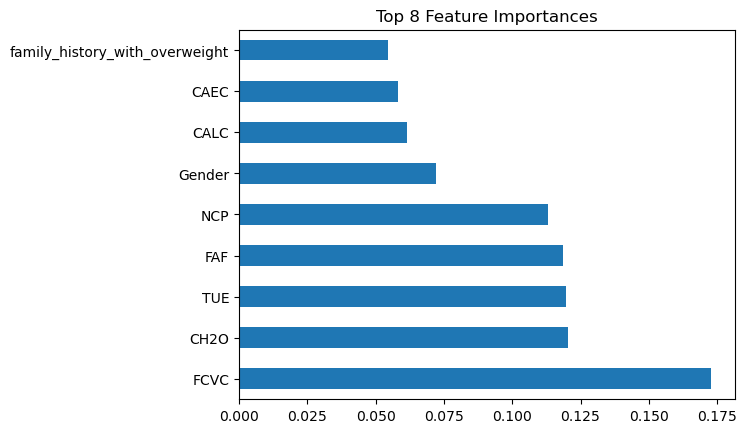

In [13]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(rf_model.feature_importances_, index=removed_merge.columns)
feature_importances.nlargest(9).plot(kind='barh')
plt.title("Top 8 Feature Importances")
plt.show()

In [11]:
feature_importances

Gender                            0.071953
family_history_with_overweight    0.054355
FAVC                              0.030442
FCVC                              0.172870
NCP                               0.112943
CAEC                              0.058281
SMOKE                             0.006508
CH2O                              0.120336
SCC                               0.013273
FAF                               0.118564
TUE                               0.119633
CALC                              0.061566
MTRANS_Bike                       0.001018
MTRANS_Motorbike                  0.001887
MTRANS_Public_Transportation      0.047606
MTRANS_Walking                    0.008763
dtype: float64

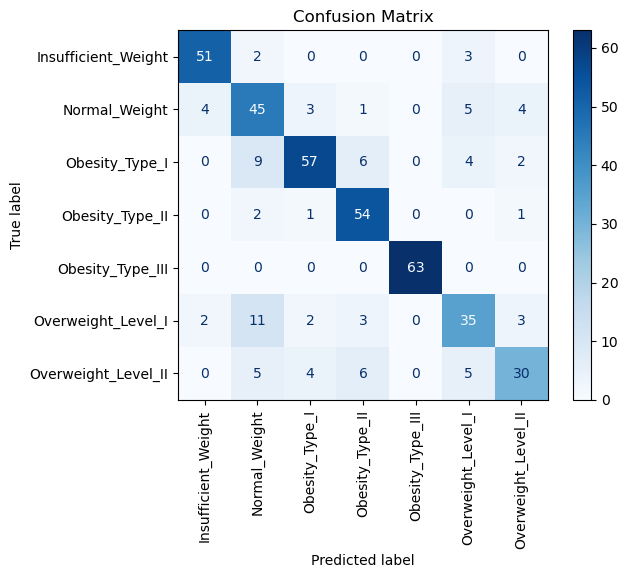

In [10]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)

# Rotate the x-axis labels
plt.xticks(rotation=90)
plt.title("Confusion Matrix")
plt.show()
